<a href="https://colab.research.google.com/github/fjadidi2001/fake_news_detection/blob/main/fake_news_detection_GAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ==========================================
# STEP 1: SETUP AND IMPORTS
# ==========================================

# Install dependencies
!pip install torch-geometric imbalanced-learn -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from scipy import io as sio
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
# plt.style.use('seaborn-v0_8-darkgrid')
# sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [10]:
# Reproducibility
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Mounted at /content/drive
Dataset shape: (2282, 13)
Columns: ['account_id', 'post_id', 'Category', 'Page', 'Post URL', 'Date Published', 'Post Type', 'Rating', 'Debate', 'share_count', 'reaction_count', 'comment_count', 'Context Post']
First 5 rows:
     account_id       post_id    Category               Page  \
0  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
1  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
2  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
3  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
4  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   

                                            Post URL Date Published Post Type  \
0  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016     video   
1  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016      link   
2  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016      link   
3  https://www.facebook.com/ABCNewsPoliti

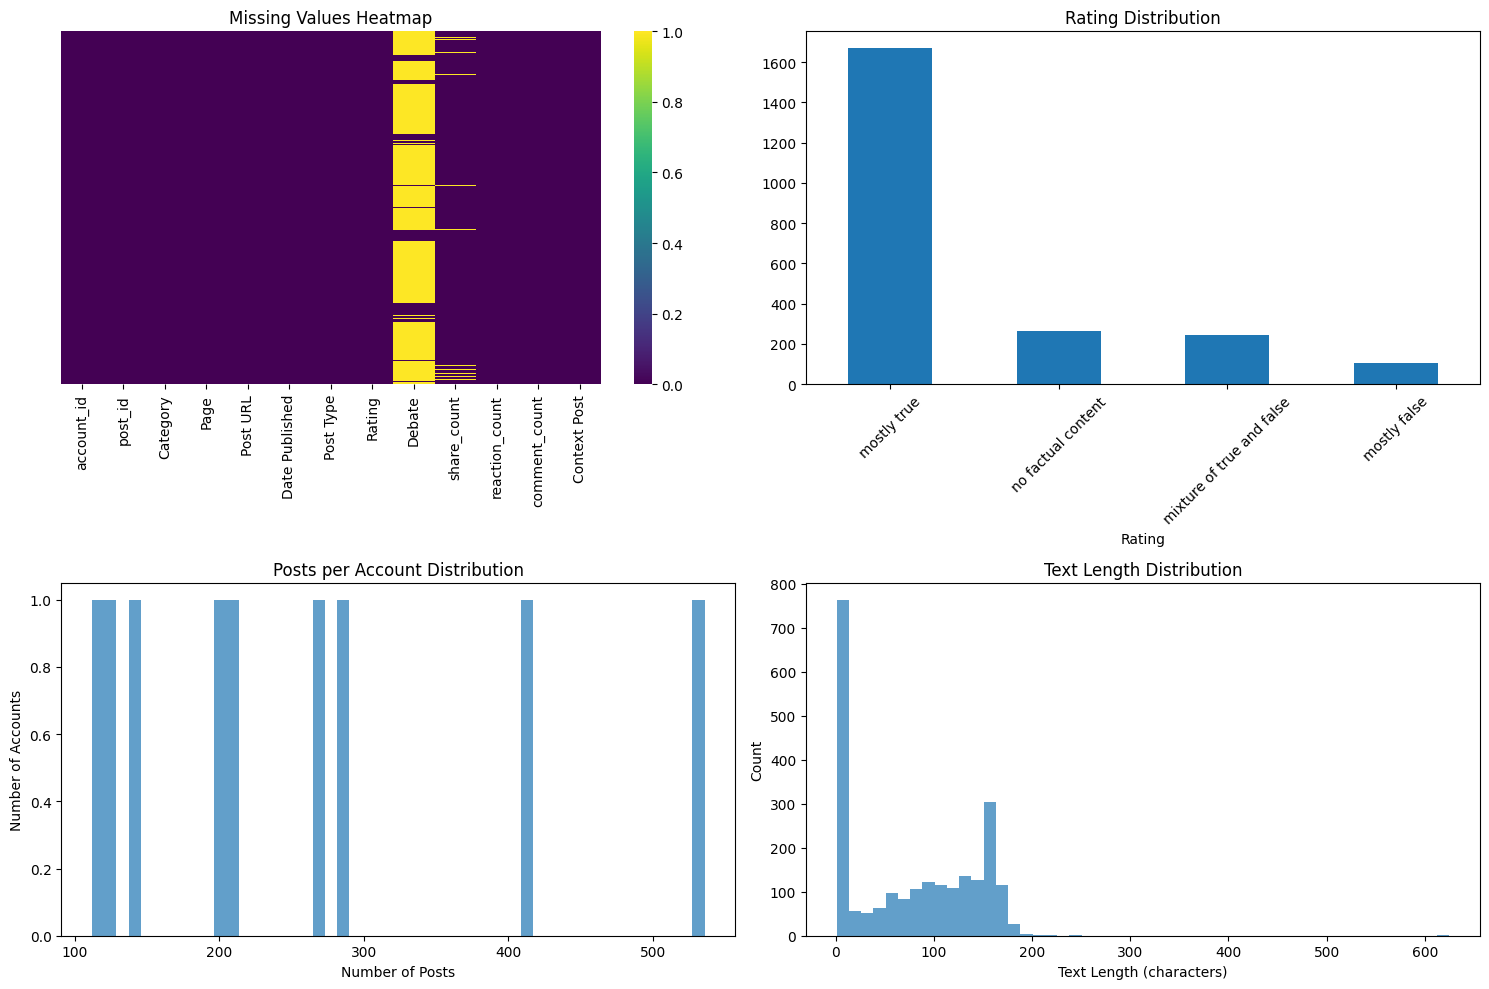

In [11]:
# ==========================================
# STEP 2: DATA LOADING AND INITIAL EXPLORATION
# ==========================================

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv', encoding='latin-1')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"First 5 rows:")
print(df.head())

# Basic statistics
print(f"\nDataset Info:")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1]}")
print(f"Missing values per column:")
print(df.isnull().sum())

# Visualize dataset overview
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Missing values heatmap
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('Missing Values Heatmap')

# 2. Rating distribution
df['Rating'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Rating Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Account activity distribution
account_counts = df['account_id'].value_counts()
axes[1,0].hist(account_counts.values, bins=50, alpha=0.7)
axes[1,0].set_title('Posts per Account Distribution')
axes[1,0].set_xlabel('Number of Posts')
axes[1,0].set_ylabel('Number of Accounts')

# 4. Text length distribution
text_lengths = df['Context Post'].fillna('').str.len()
axes[1,1].hist(text_lengths, bins=50, alpha=0.7)
axes[1,1].set_title('Text Length Distribution')
axes[1,1].set_xlabel('Text Length (characters)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

✅ Network features preprocessed
Raw features shape: (2282, 3)
Processed features shape: (2282, 3)


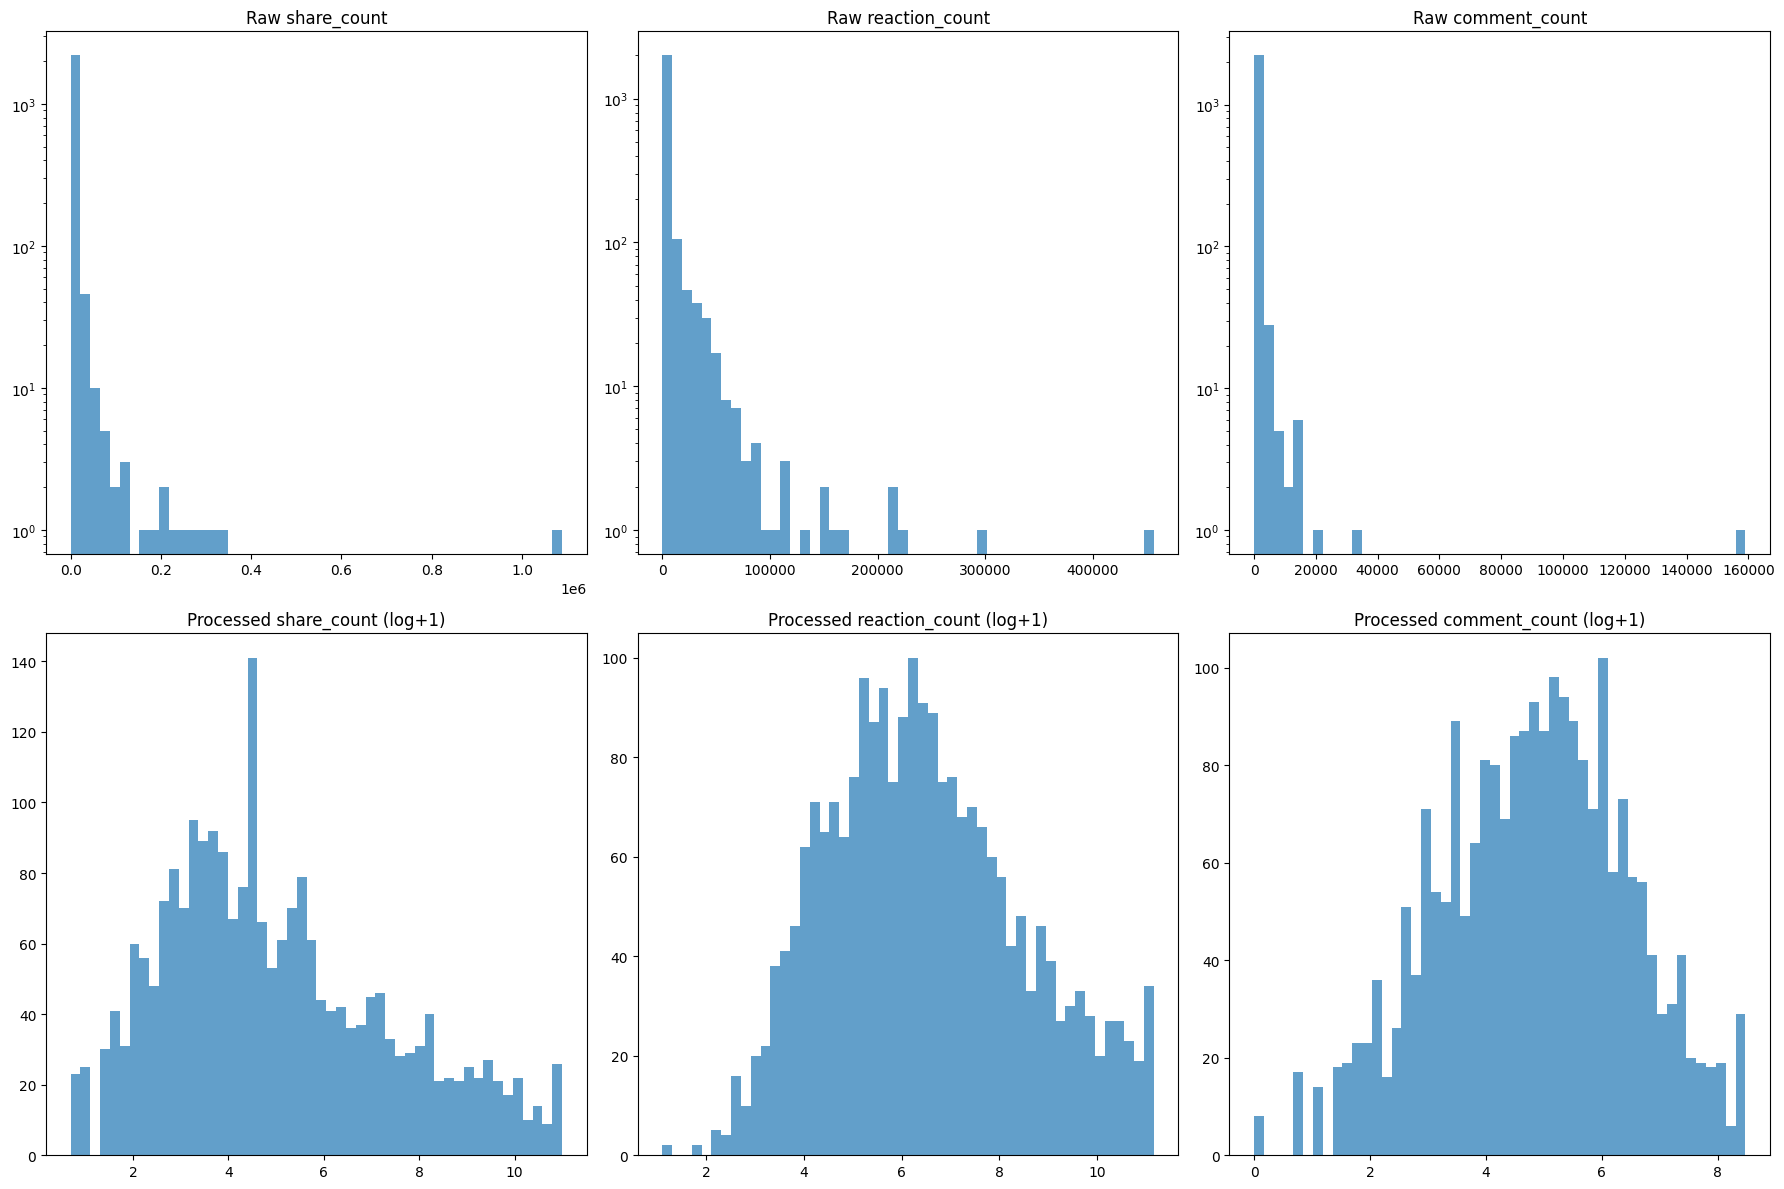

Standardized features shape: (2282, 3)
NaN check: False


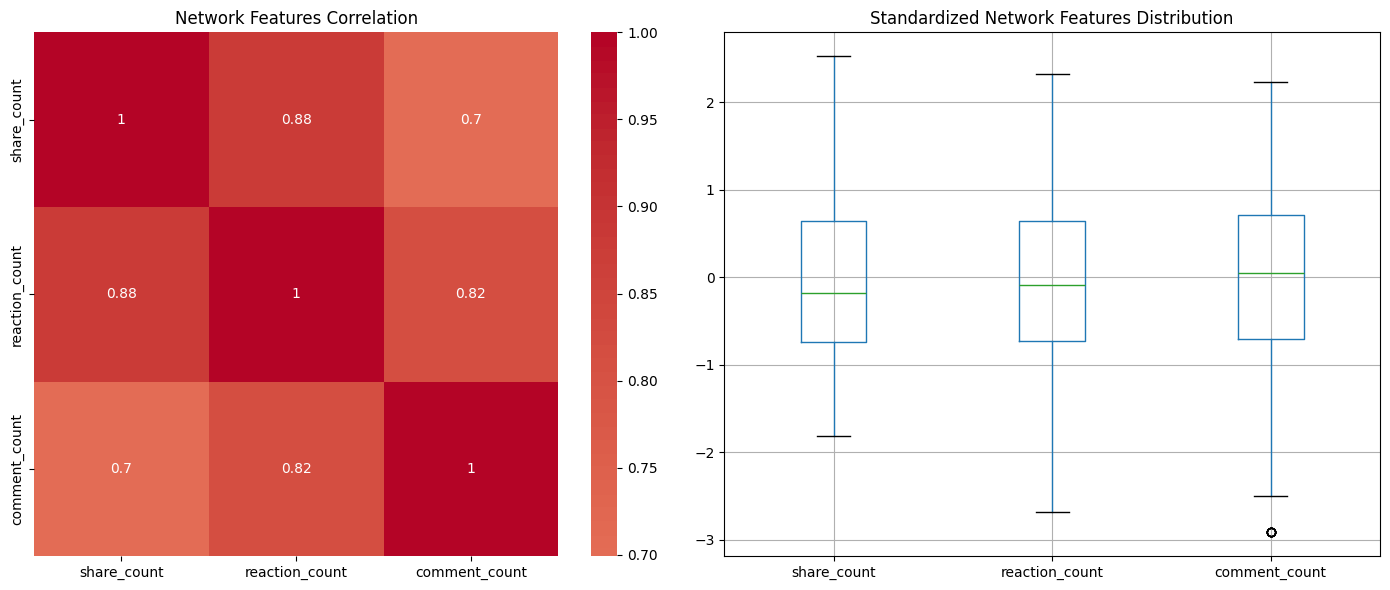

In [12]:
# ==========================================
# STEP 3: NETWORK FEATURES PREPROCESSING
# ==========================================

def preprocess_network_features(df):
    """Enhanced preprocessing with outlier handling and normalization"""
    # Extract network features
    network_cols = ['share_count', 'reaction_count', 'comment_count']
    features = df[network_cols].copy()

    # Handle missing values
    features = features.fillna(features.median())


    # Log transform to handle skewness (add 1 to avoid log(0))
    features_log = np.log1p(features)

    # Optional: Cap extreme outliers at 99th percentile
    for col in features_log.columns:
        q99 = features_log[col].quantile(0.99)
        features_log[col] = features_log[col].clip(upper=q99)

    return features_log.values, features.values

# Preprocess network features
network_features_processed, network_features_raw = preprocess_network_features(df)

print("✅ Network features preprocessed")
print(f"Raw features shape: {network_features_raw.shape}")
print(f"Processed features shape: {network_features_processed.shape}")

# Visualize network features preprocessing
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Raw features
for i, col in enumerate(['share_count', 'reaction_count', 'comment_count']):
    axes[0, i].hist(network_features_raw[:, i], bins=50, alpha=0.7)
    axes[0, i].set_title(f'Raw {col}')
    axes[0, i].set_yscale('log')

    axes[1, i].hist(network_features_processed[:, i], bins=50, alpha=0.7)
    axes[1, i].set_title(f'Processed {col} (log+1)')

plt.tight_layout()
plt.show()

# Standardize network features
scaler = StandardScaler()
X_net_std = scaler.fit_transform(network_features_processed)

print(f"Standardized features shape: {X_net_std.shape}")
print(f"NaN check: {np.isnan(X_net_std).any()}")

# Save for later use
sio.savemat('/content/drive/MyDrive/Projects/Hayat/network_processed.mat', {
    'X_net_std': X_net_std,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_
})

# Visualize correlation and distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation heatmap
corr_matrix = pd.DataFrame(X_net_std, columns=['share_count', 'reaction_count', 'comment_count']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Network Features Correlation')

# Distribution after standardization
pd.DataFrame(X_net_std, columns=['share_count', 'reaction_count', 'comment_count']).boxplot(ax=axes[1])
axes[1].set_title('Standardized Network Features Distribution')

plt.tight_layout()
plt.show()

Label distribution: [1669  613]
Class 0 (mostly true): 1669 (73.1%)
Class 1 (others): 613 (26.9%)


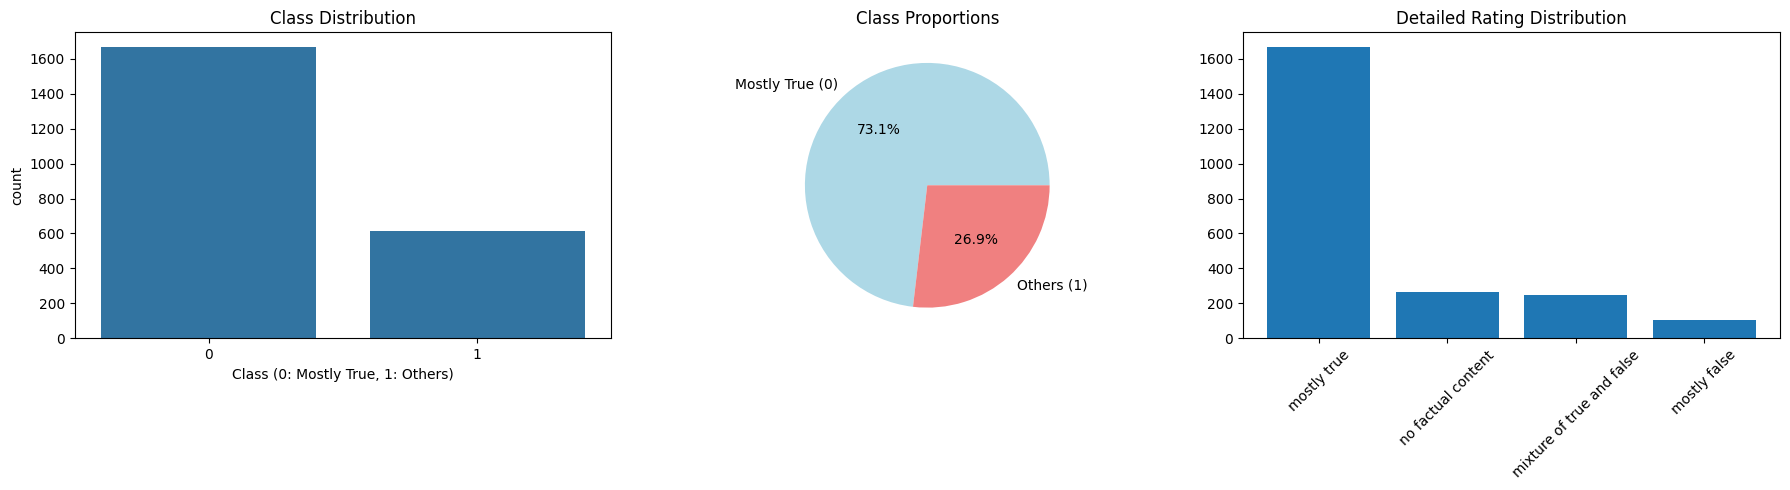

In [13]:
# ==========================================
# STEP 4: LABEL PREPARATION AND ANALYSIS
# ==========================================

# Prepare labels (binary classification)
labels = df['Rating'].apply(lambda x: 0 if x == 'mostly true' else 1).values
y = np.array(labels)

print(f"Label distribution: {np.bincount(y)}")
print(f"Class 0 (mostly true): {np.bincount(y)[0]} ({np.bincount(y)[0]/len(y)*100:.1f}%)")
print(f"Class 1 (others): {np.bincount(y)[1]} ({np.bincount(y)[1]/len(y)*100:.1f}%)")

# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Count plot
sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution")
axes[0].set_xlabel("Class (0: Mostly True, 1: Others)")

# Pie chart
labels_pie = ['Mostly True (0)', 'Others (1)']
colors = ['lightblue', 'lightcoral']
axes[1].pie(np.bincount(y), labels=labels_pie, autopct='%1.1f%%', colors=colors)
axes[1].set_title("Class Proportions")

# Class distribution by rating
rating_counts = df['Rating'].value_counts()
axes[2].bar(range(len(rating_counts)), rating_counts.values)
axes[2].set_xticks(range(len(rating_counts)))
axes[2].set_xticklabels(rating_counts.index, rotation=45)
axes[2].set_title("Detailed Rating Distribution")

plt.tight_layout()
plt.show()



🔄 Constructing graph with similarity method...
Nodes: 2282, Edges: 7006
Average degree: 6.14
Degree std: 1.16

🔄 Constructing graph with account method...
Nodes: 2282, Edges: 90
Average degree: 0.08
Degree std: 0.56

🔄 Constructing graph with hybrid method...
Nodes: 2282, Edges: 4319
Average degree: 3.79
Degree std: 0.94


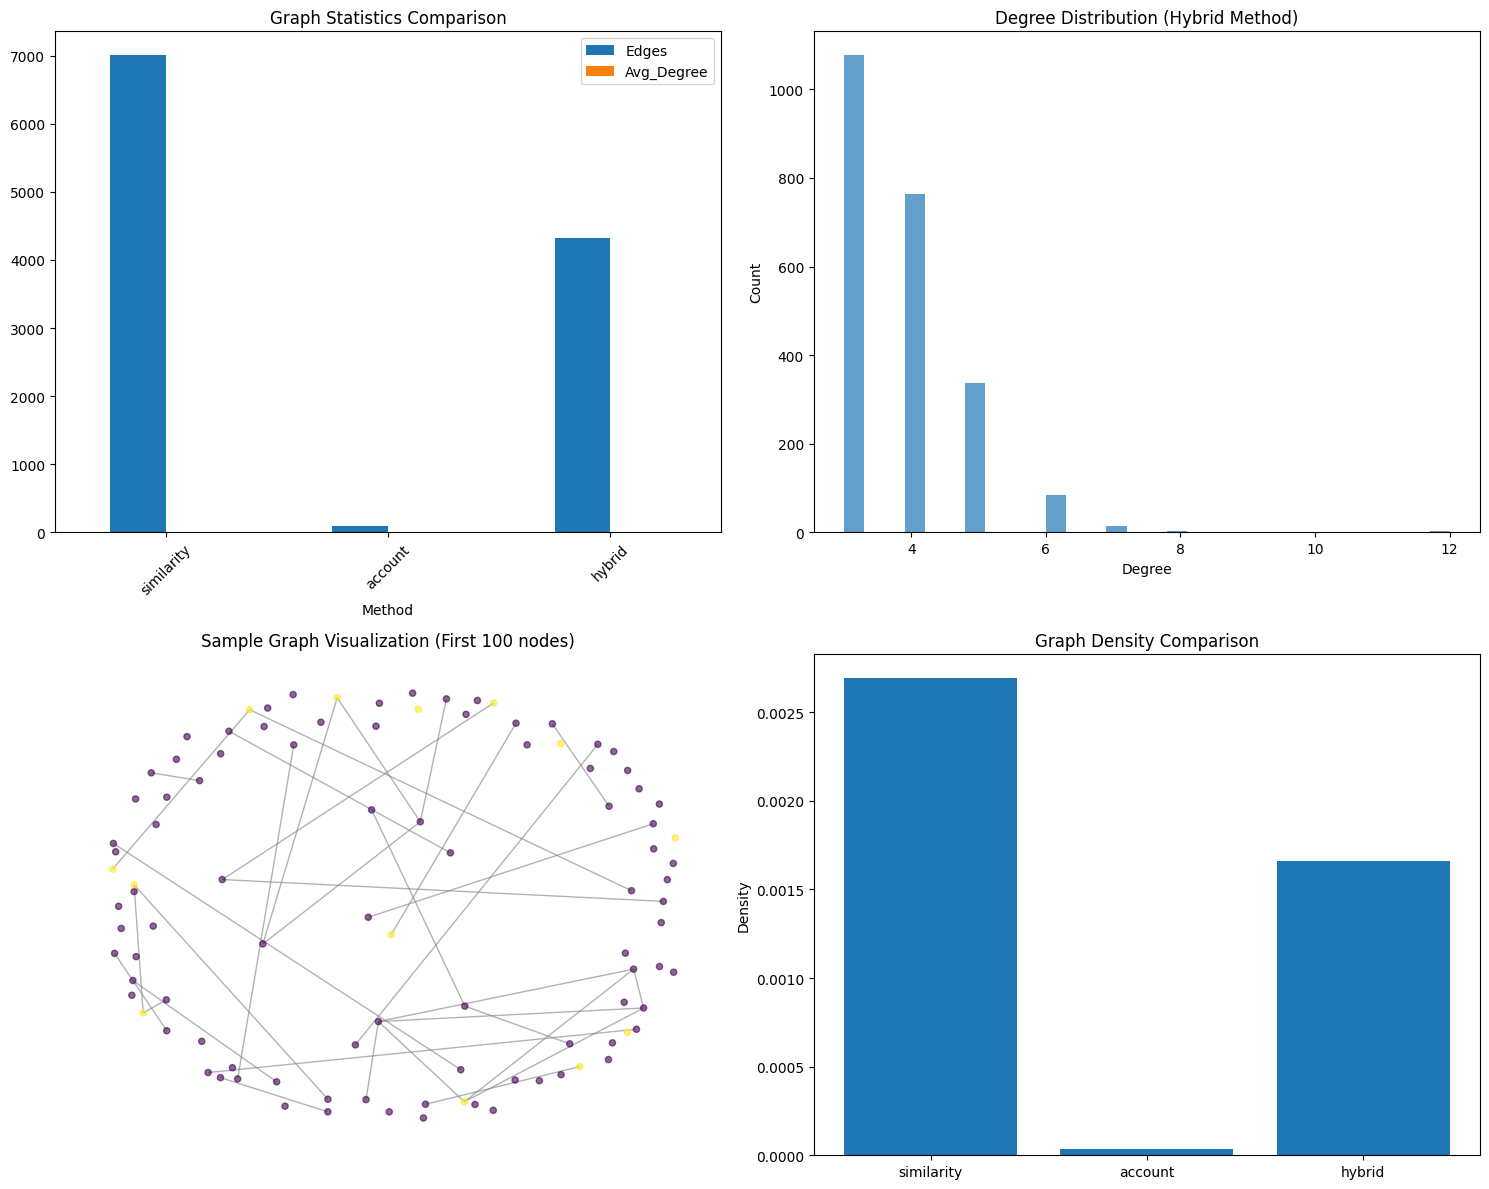


✅ Final graph selected: 2282 nodes, 4319 edges


In [14]:
# ==========================================
# STEP 5: IMPROVED GRAPH CONSTRUCTION
# ==========================================

def construct_meaningful_graph(df, X_net_std, method='hybrid', similarity_threshold=0.7, max_connections=5):
    """
    Construct graph with meaningful connections
    Methods: 'similarity', 'account', 'hybrid'
    """
    G = nx.Graph()

    # Add nodes with features
    for idx in range(len(df)):
        G.add_node(idx, features=X_net_std[idx])

    if method == 'similarity':
        # Similarity-based edges
        similarity_matrix = cosine_similarity(X_net_std)
        for i in range(len(df)):
            # Find most similar posts
            similarities = similarity_matrix[i]
            similar_indices = np.argsort(similarities)[::-1][1:max_connections+1]  # Exclude self
            for j in similar_indices:
                if similarities[j] > similarity_threshold:
                    G.add_edge(i, j, weight=similarities[j])

    elif method == 'account':
        # Account-based edges (limited)
        account_groups = df.groupby('account_id').indices
        for account_id, indices in account_groups.items():
            indices = list(indices)
            if len(indices) > 1:
                # Connect only recent posts (limit connections)
                for i in range(min(len(indices), max_connections)):
                    for j in range(i + 1, min(len(indices), max_connections)):
                        G.add_edge(indices[i], indices[j], weight=1.0)

    elif method == 'hybrid':
        # Combination of both methods
        # First add account-based edges
        account_groups = df.groupby('account_id').indices
        for account_id, indices in account_groups.items():
            indices = list(indices)
            if len(indices) > 1:
                for i in range(min(len(indices), 3)):  # Limit account connections
                    for j in range(i + 1, min(len(indices), 3)):
                        G.add_edge(indices[i], indices[j], weight=1.0)

        # Then add similarity-based edges
        similarity_matrix = cosine_similarity(X_net_std)
        for i in range(len(df)):
            similarities = similarity_matrix[i]
            similar_indices = np.argsort(similarities)[::-1][1:4]  # Top 3 similar
            for j in similar_indices:
                if similarities[j] > similarity_threshold and not G.has_edge(i, j):
                    G.add_edge(i, j, weight=similarities[j])

    return G

# Test different graph construction methods
methods = ['similarity', 'account', 'hybrid']
graphs = {}

for method in methods:
    print(f"\n🔄 Constructing graph with {method} method...")
    G = construct_meaningful_graph(df, X_net_std, method=method)
    graphs[method] = G
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    if G.number_of_nodes() > 0:
        degrees = [d for _, d in G.degree()]
        print(f"Average degree: {np.mean(degrees):.2f}")
        print(f"Degree std: {np.std(degrees):.2f}")

# Visualize graph statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Graph statistics comparison
stats_data = []
for method, G in graphs.items():
    if G.number_of_nodes() > 0:
        degrees = [d for _, d in G.degree()]
        stats_data.append({
            'Method': method,
            'Nodes': G.number_of_nodes(),
            'Edges': G.number_of_edges(),
            'Avg_Degree': np.mean(degrees),
            'Density': nx.density(G)
        })

stats_df = pd.DataFrame(stats_data)
stats_df.set_index('Method')[['Edges', 'Avg_Degree']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Graph Statistics Comparison')
axes[0,0].tick_params(axis='x', rotation=45)

# Degree distribution for hybrid method
if 'hybrid' in graphs:
    degrees = [d for _, d in graphs['hybrid'].degree()]
    axes[0,1].hist(degrees, bins=30, alpha=0.7)
    axes[0,1].set_title('Degree Distribution (Hybrid Method)')
    axes[0,1].set_xlabel('Degree')
    axes[0,1].set_ylabel('Count')

# Network visualization (sample)
if 'hybrid' in graphs and graphs['hybrid'].number_of_nodes() > 0:
    # Sample a subgraph for visualization
    sample_nodes = list(graphs['hybrid'].nodes())[:100]  # Sample first 100 nodes
    subgraph = graphs['hybrid'].subgraph(sample_nodes)

    pos = nx.spring_layout(subgraph, k=1, iterations=50)

    # Color nodes by labels
    node_colors = [y[node] for node in subgraph.nodes()]

    nx.draw(subgraph, pos, node_color=node_colors, node_size=20,
            with_labels=False, edge_color='gray', alpha=0.6, ax=axes[1,0])
    axes[1,0].set_title('Sample Graph Visualization (First 100 nodes)')

# Graph density comparison
methods_list = list(graphs.keys())
densities = [nx.density(graphs[method]) if graphs[method].number_of_nodes() > 0 else 0 for method in methods_list]
axes[1,1].bar(methods_list, densities)
axes[1,1].set_title('Graph Density Comparison')
axes[1,1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Use hybrid method for final graph
final_graph = graphs['hybrid']
print(f"\n✅ Final graph selected: {final_graph.number_of_nodes()} nodes, {final_graph.number_of_edges()} edges")


PyTorch Geometric Data: Data(x=[2282, 3], edge_index=[2, 6601])
Using device: cuda
GCN embeddings shape: torch.Size([2282, 128])
NaN check: False


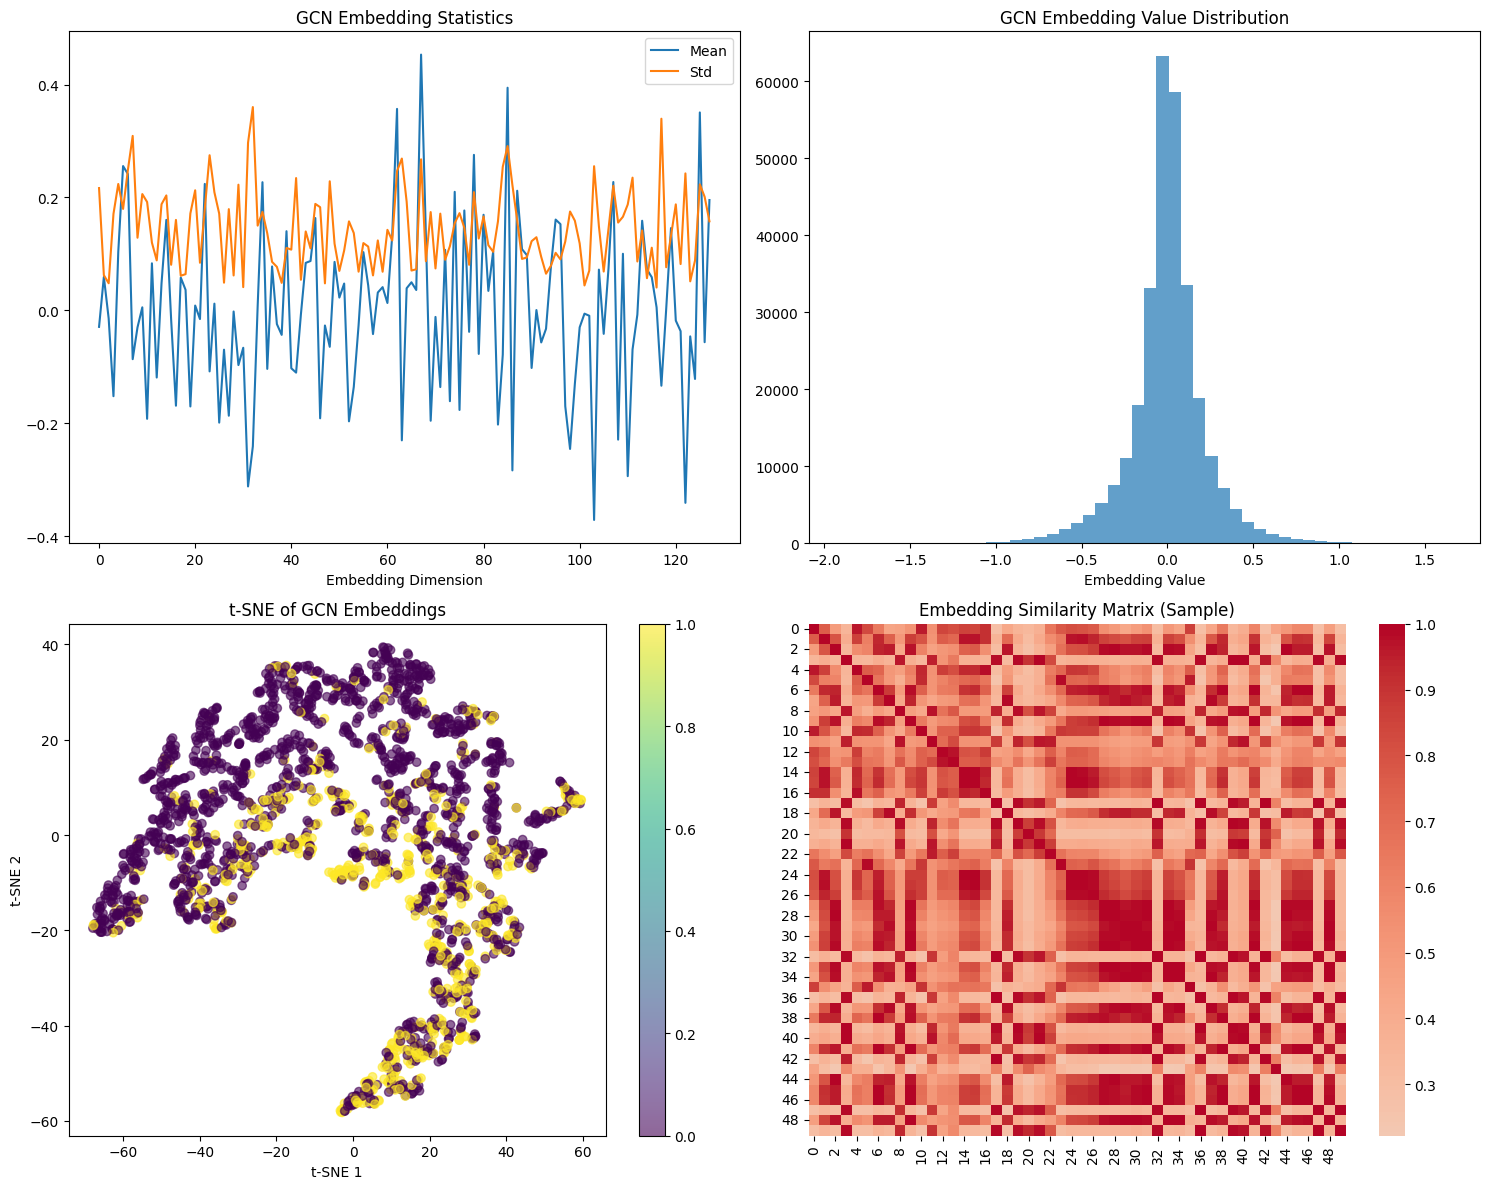

✅ GCN model and embeddings saved


In [15]:
# ==========================================
# STEP 6: GCN MODEL AND SOCIAL BRANCH
# ==========================================

# Convert NetworkX graph to PyTorch Geometric format
edges = list(final_graph.edges)
if len(edges) == 0:
    # Create self-loops for all nodes if graph is empty
    edge_index = torch.arange(len(df), dtype=torch.long).repeat(2, 1)
else:
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    # Ensure edge_index is of shape [2, num_edges]
    assert edge_index.shape[0] == 2, f"Edge index must have shape [2, num_edges], got {edge_index.shape}"

x = torch.tensor(X_net_std, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

# Add self-loops
edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
data.edge_index = edge_index

print(f"PyTorch Geometric Data: {data}")

# Define improved GCN model
class ImprovedGCN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=128, dropout=0.3):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.relu(x)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Third GCN layer
        x = self.conv3(x, edge_index)

        return x

# Initialize and train GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

gcn_model = ImprovedGCN().to(device)
data = data.to(device)

# Get GCN embeddings
gcn_model.eval()
with torch.no_grad():
    gcn_embeddings = gcn_model(data)

print(f"GCN embeddings shape: {gcn_embeddings.shape}")
print(f"NaN check: {torch.isnan(gcn_embeddings).any().item()}")

# Visualize GCN embeddings
gcn_embeddings_cpu = gcn_embeddings.cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Embedding statistics
embedding_stats = pd.DataFrame({
    'Mean': gcn_embeddings_cpu.mean(axis=0),
    'Std': gcn_embeddings_cpu.std(axis=0),
    'Min': gcn_embeddings_cpu.min(axis=0),
    'Max': gcn_embeddings_cpu.max(axis=0)
})

embedding_stats[['Mean', 'Std']].plot(ax=axes[0,0])
axes[0,0].set_title('GCN Embedding Statistics')
axes[0,0].set_xlabel('Embedding Dimension')

# 2. Embedding distribution
axes[0,1].hist(gcn_embeddings_cpu.flatten(), bins=50, alpha=0.7)
axes[0,1].set_title('GCN Embedding Value Distribution')
axes[0,1].set_xlabel('Embedding Value')

# 3. t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
gcn_tsne = tsne.fit_transform(gcn_embeddings_cpu)

scatter = axes[1,0].scatter(gcn_tsne[:, 0], gcn_tsne[:, 1], c=y, cmap='viridis', alpha=0.6)
axes[1,0].set_title('t-SNE of GCN Embeddings')
axes[1,0].set_xlabel('t-SNE 1')
axes[1,0].set_ylabel('t-SNE 2')
plt.colorbar(scatter, ax=axes[1,0])

# 4. Embedding similarity heatmap (sample)
sample_indices = np.random.choice(len(gcn_embeddings_cpu), 50, replace=False)
sample_embeddings = gcn_embeddings_cpu[sample_indices]
similarity_matrix = cosine_similarity(sample_embeddings)

sns.heatmap(similarity_matrix, ax=axes[1,1], cmap='coolwarm', center=0)
axes[1,1].set_title('Embedding Similarity Matrix (Sample)')

plt.tight_layout()
plt.show()

# Save GCN model and embeddings
torch.save(gcn_model.state_dict(), '/content/drive/MyDrive/Projects/Hayat/improved_gcn_model.pth')
torch.save(gcn_embeddings.cpu(), '/content/drive/MyDrive/Projects/Hayat/gcn_embeddings.pt')
print("✅ GCN model and embeddings saved")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing 2282 texts...
Optimal max_length: 51
Processed 160 texts...
Processed 320 texts...
Processed 480 texts...
Processed 640 texts...
Processed 800 texts...
Processed 960 texts...
Processed 1120 texts...
Processed 1280 texts...
Processed 1440 texts...
Processed 1600 texts...
Processed 1760 texts...
Processed 1920 texts...
Processed 2080 texts...
Processed 2240 texts...
BERT embeddings shape: torch.Size([2282, 768])
NaN check: False


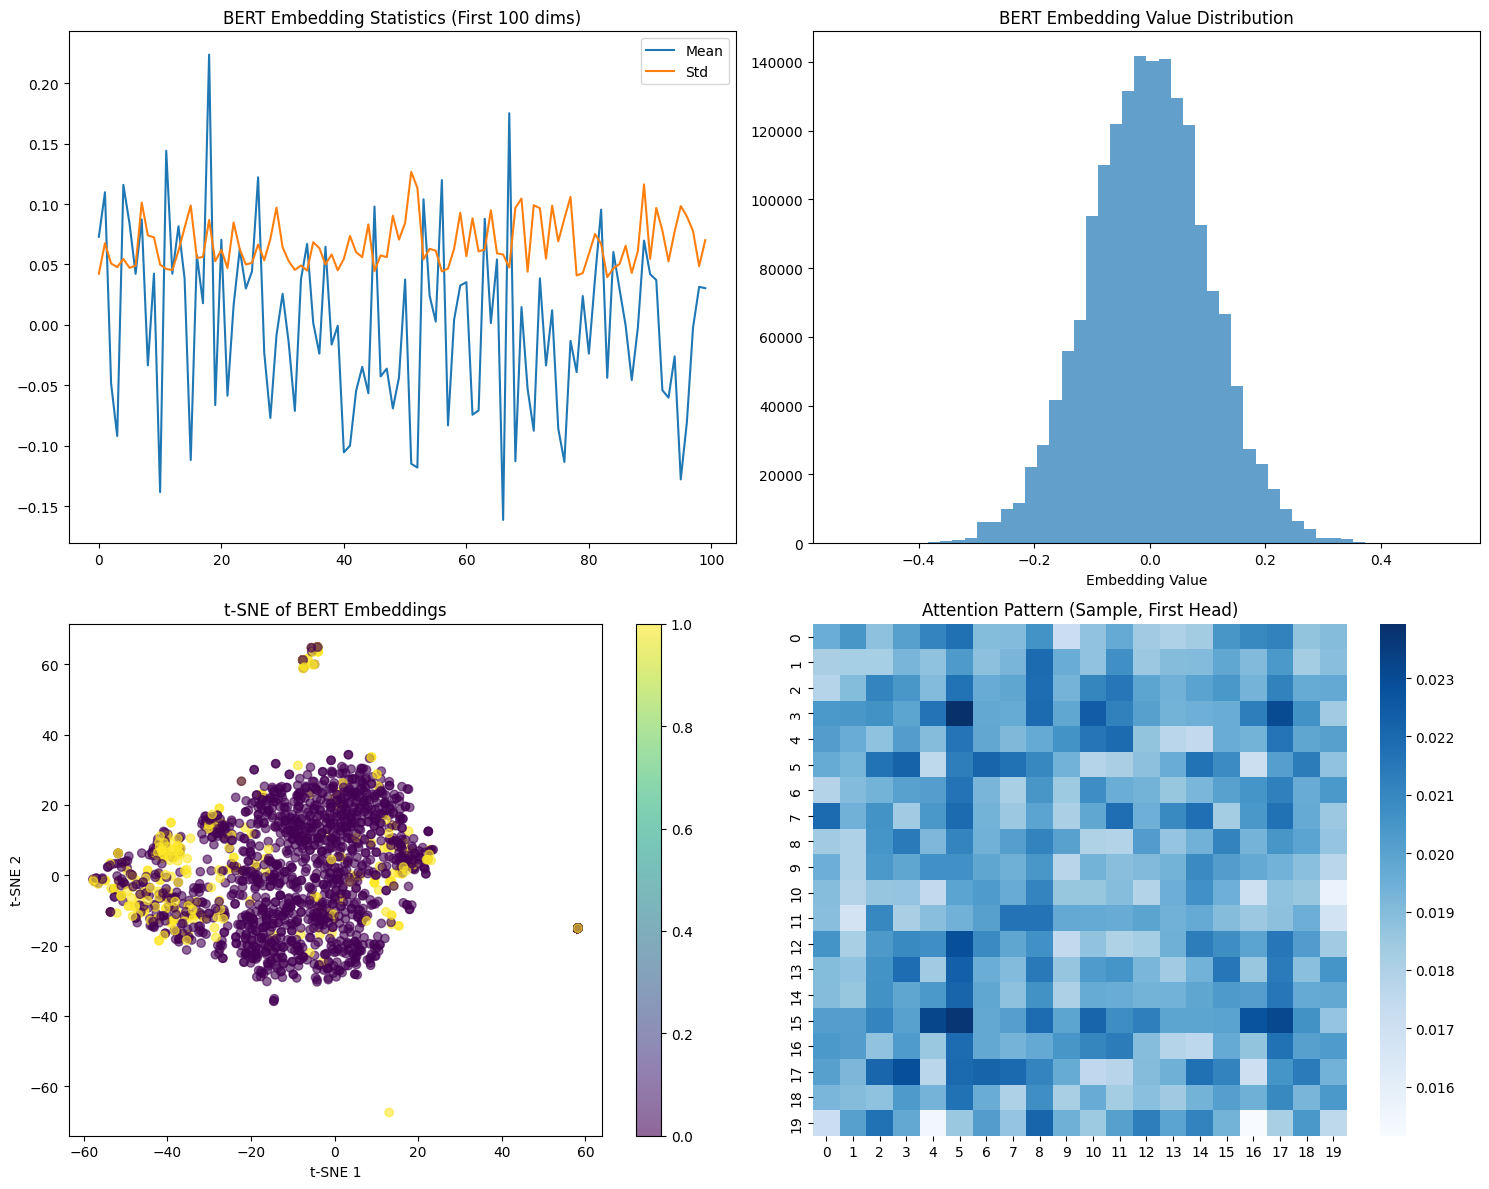

✅ BERT embeddings saved


In [16]:
# ==========================================
# STEP 7: BERT MODEL AND TEXT BRANCH
# ==========================================

# Define improved attention mechanism
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads

        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, embeddings):
        batch_size, seq_len, hidden_dim = embeddings.shape

        # Generate Q, K, V
        Q = self.query(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim)
        K = self.key(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim)
        V = self.value(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim)

        # Transpose for attention computation
        Q = Q.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention_weights = torch.softmax(scores, dim=-1)

        # Apply attention
        context = torch.matmul(attention_weights, V)

        # Reshape and output
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_dim)
        output = self.output(context)

        # Global average pooling
        output = output.mean(dim=1)  # (batch_size, hidden_dim)

        return output, attention_weights

# Initialize BERT and attention
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

attention_layer = MultiHeadAttention(hidden_dim=768, num_heads=8).to(device)

# Process texts with BERT
batch_size = 16  # Reduced batch size for stability
bert_embeddings = []
attention_weights_sample = []

texts = df['Context Post'].fillna("").tolist()
print(f"Processing {len(texts)} texts...")

# Calculate optimal max_length
text_lengths = [len(tokenizer.tokenize(text)) for text in texts[:100]]  # Sample
optimal_max_length = int(np.percentile(text_lengths, 95))
print(f"Optimal max_length: {optimal_max_length}")

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]

    # Tokenize
    inputs = tokenizer(
        batch_texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=min(optimal_max_length, 512)
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # Get BERT outputs
        outputs = bert_model(**inputs)
        token_embeddings = outputs.last_hidden_state  # (batch_size, seq_len, 768)

        # Apply attention and get attention weights
        context_vector, attention_weights = attention_layer(token_embeddings)  # (batch_size, 768), (batch_size, num_heads, seq_len, seq_len)
        bert_embeddings.append(context_vector.cpu())

        # Store sample attention weights for visualization (first batch only)
        if i == 0:
            attention_weights_sample = attention_weights[0].cpu().numpy()  # Store first sample's attention weights

    if (i // batch_size + 1) % 10 == 0:
        print(f"Processed {i + batch_size} texts...")

# Concatenate all batches
bert_embeddings = torch.cat(bert_embeddings, dim=0)
print(f"BERT embeddings shape: {bert_embeddings.shape}")
print(f"NaN check: {torch.isnan(bert_embeddings).any().item()}")

# Visualize BERT embeddings and attention
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. BERT embedding statistics
bert_embeddings_np = bert_embeddings.numpy()
embedding_stats = pd.DataFrame({
    'Mean': bert_embeddings_np.mean(axis=0),
    'Std': bert_embeddings_np.std(axis=0)
})

axes[0,0].plot(embedding_stats['Mean'][:100], label='Mean')
axes[0,0].plot(embedding_stats['Std'][:100], label='Std')
axes[0,0].set_title('BERT Embedding Statistics (First 100 dims)')
axes[0,0].legend()

# 2. Embedding distribution
axes[0,1].hist(bert_embeddings_np.flatten(), bins=50, alpha=0.7)
axes[0,1].set_title('BERT Embedding Value Distribution')
axes[0,1].set_xlabel('Embedding Value')

# 3. t-SNE visualization
bert_tsne = tsne.fit_transform(bert_embeddings_np)
scatter = axes[1,0].scatter(bert_tsne[:, 0], bert_tsne[:, 1], c=y, cmap='viridis', alpha=0.6)
axes[1,0].set_title('t-SNE of BERT Embeddings')
axes[1,0].set_xlabel('t-SNE 1')
axes[1,0].set_ylabel('t-SNE 2')
plt.colorbar(scatter, ax=axes[1,0])

# 4. Attention visualization (sample)
if attention_weights_sample.size > 0:
    # Show attention pattern for first head of first sample
    attention_sample = attention_weights_sample[0, :20, :20]  # First head, first 20x20 tokens
    sns.heatmap(attention_sample, ax=axes[1,1], cmap='Blues')
    axes[1,1].set_title('Attention Pattern (Sample, First Head)')

plt.tight_layout()
plt.show()

# Save BERT embeddings
torch.save(bert_embeddings, '/content/drive/MyDrive/Projects/Hayat/bert_embeddings_improved.pt')
print("✅ BERT embeddings saved")

In [17]:

# ==========================================
# STEP 8: TWO-BRANCH ARCHITECTURE IMPLEMENTATION
# ==========================================

class TwoBranchClassifier(nn.Module):
    def __init__(self, gcn_dim=128, bert_dim=768, hidden_dim=256, num_classes=2, dropout=0.4):
        super(TwoBranchClassifier, self).__init__()

        # Social branch (GCN features)
        self.social_branch = nn.Sequential(
            nn.Linear(gcn_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Text branch (BERT features)
        self.text_branch = nn.Sequential(
            nn.Linear(bert_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Fusion layer with attention
        self.fusion_attention = nn.Sequential(
            nn.Linear(num_classes * 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 2),  # Attention weights for social and text
            nn.Softmax(dim=1)
        )

        self.final_classifier = nn.Linear(num_classes, num_classes)

    def forward(self, gcn_features, bert_features):
        # Get predictions from both branches
        social_out = self.social_branch(gcn_features)
        text_out = self.text_branch(bert_features)

        # Concatenate for attention computation
        combined = torch.cat([social_out, text_out], dim=1)

        # Compute attention weights
        attention_weights = self.fusion_attention(combined)  # (batch_size, 2)

        # Apply attention to combine predictions
        weighted_social = social_out * attention_weights[:, 0:1]
        weighted_text = text_out * attention_weights[:, 1:2]

        # Final prediction
        final_features = weighted_social + weighted_text
        final_out = self.final_classifier(final_features)

        return final_out, social_out, text_out, attention_weights

# Initialize the model
two_branch_model = TwoBranchClassifier().to(device)
print(f"Model parameters: {sum(p.numel() for p in two_branch_model.parameters()):,}")

Model parameters: 298,188


Original class distribution: [1669  613]
After SMOTE - class distribution: [1669 1669]
Resampled GCN shape: torch.Size([3338, 128])
Resampled BERT shape: torch.Size([3338, 768])
Training set size: 2670
Test set size: 668


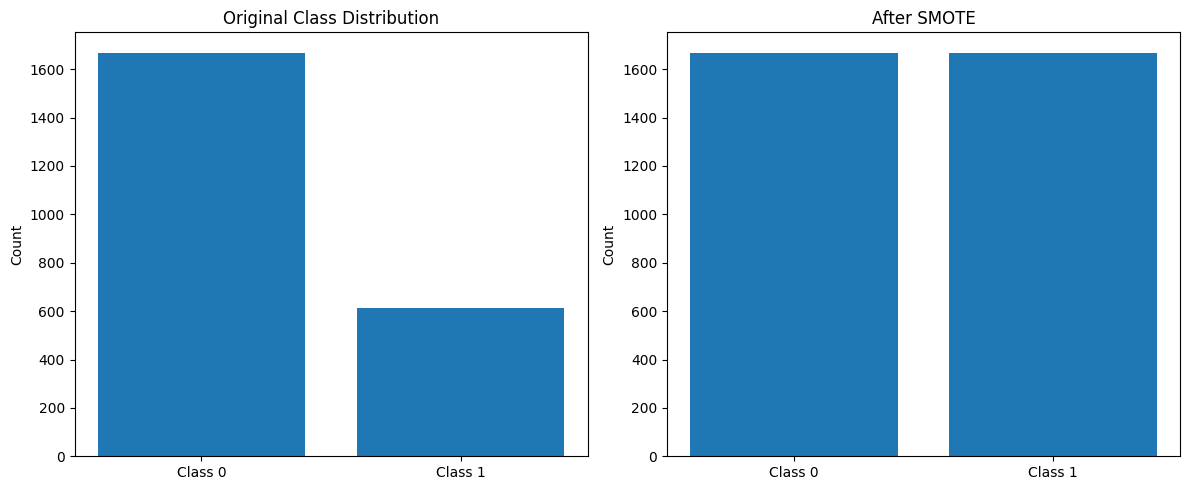

In [18]:
# ==========================================
# STEP 9: DATA PREPARATION AND SMOTE (CONTINUED)
# ==========================================

# Address class imbalance with SMOTE
print(f"Original class distribution: {np.bincount(y)}")

smote = SMOTE(random_state=42, k_neighbors=5)
X_gcn_resampled, y_resampled = smote.fit_resample(gcn_embeddings.cpu().numpy(), y)
X_bert_resampled, _ = smote.fit_resample(bert_embeddings.numpy(), y)

# Convert back to tensors
X_gcn_resampled = torch.tensor(X_gcn_resampled, dtype=torch.float)
X_bert_resampled = torch.tensor(X_bert_resampled, dtype=torch.float)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

print(f"After SMOTE - class distribution: {np.bincount(y_resampled)}")
print(f"Resampled GCN shape: {X_gcn_resampled.shape}")
print(f"Resampled BERT shape: {X_bert_resampled.shape}")

# Train-test split
X_gcn_train, X_gcn_test, X_bert_train, X_bert_test, y_train, y_test = train_test_split(
    X_gcn_resampled, X_bert_resampled, y_resampled,
    test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"Training set size: {len(X_gcn_train)}")
print(f"Test set size: {len(X_gcn_test)}")

# Create DataLoaders
train_dataset = TensorDataset(X_gcn_train, X_bert_train, y_train)
test_dataset = TensorDataset(X_gcn_test, X_bert_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize class distribution after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
axes[0].bar(['Class 0', 'Class 1'], np.bincount(y))
axes[0].set_title('Original Class Distribution')
axes[0].set_ylabel('Count')

# After SMOTE
axes[1].bar(['Class 0', 'Class 1'], np.bincount(y_resampled))
axes[1].set_title('After SMOTE')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [22]:
# ==========================================
# STEP 10: MODEL TRAINING WITH COMPREHENSIVE MONITORING
# ==========================================

def train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    """Enhanced training function with comprehensive monitoring"""

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'attention_weights': [],
        'social_acc': [],
        'text_acc': [],
        'learning_rate': []  # Initialize learning_rate key
    }

    best_val_acc = 0.0
    patience_counter = 0
    early_stopping_patience = 10

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        social_correct = 0
        text_correct = 0
        epoch_attention_weights = []

        for batch_gcn, batch_bert, batch_y in train_loader:
            batch_gcn, batch_bert, batch_y = batch_gcn.to(device), batch_bert.to(device), batch_y.to(device)

            optimizer.zero_grad()

            # Forward pass
            final_out, social_out, text_out, attention_weights = model(batch_gcn, batch_bert)

            # Calculate loss
            loss = criterion(final_out, batch_y)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(final_out.data, 1)
            _, social_pred = torch.max(social_out.data, 1)
            _, text_pred = torch.max(text_out.data, 1)

            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
            social_correct += (social_pred == batch_y).sum().item()
            text_correct += (text_pred == batch_y).sum().item()

            epoch_attention_weights.append(attention_weights.cpu().detach().numpy())

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_gcn, batch_bert, batch_y in test_loader:
                batch_gcn, batch_bert, batch_y = batch_gcn.to(device), batch_bert.to(device), batch_y.to(device)

                final_out, _, _, _ = model(batch_gcn, batch_bert)
                loss = criterion(final_out, batch_y)

                val_loss += loss.item()
                _, predicted = torch.max(final_out.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(test_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        social_acc = 100 * social_correct / train_total
        text_acc = 100 * text_correct / train_total

        # Store history
        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['social_acc'].append(social_acc)
        history['text_acc'].append(text_acc)
        history['attention_weights'].append(np.concatenate(epoch_attention_weights, axis=0))

        # Learning rate scheduling
        scheduler.step(val_loss_avg)
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rate'].append(current_lr)  # Store learning rate

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), '/content/drive/MyDrive/Projects/Hayat/best_two_branch_model.pth')
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}')
            print(f'  Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
            print(f'  Social Acc: {social_acc:.2f}%, Text Acc: {text_acc:.2f}%')
            print(f'  LR: {current_lr:.6f}')
            print(f'  Attention weights (avg): Social={np.mean(epoch_attention_weights):.3f}')

        # Early stopping check
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    return history

# Train the model
print("🚀 Starting model training...")
history = train_model(two_branch_model, train_loader, test_loader, num_epochs=50, learning_rate=0.001)

🚀 Starting model training...
Epoch [5/50]
  Train Loss: 0.3950, Val Loss: 0.4252
  Train Acc: 82.40%, Val Acc: 79.49%
  Social Acc: 34.64%, Text Acc: 23.78%
  LR: 0.001000


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (84,) + inhomogeneous part.

In [ ]:
# ==========================================
# STEP 11: COMPREHENSIVE EVALUATION AND ANALYSIS
# ==========================================

def evaluate_model(model, test_loader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_social_preds = []
    all_text_preds = []
    all_attention_weights = []

    with torch.no_grad():
        for batch_gcn, batch_bert, batch_y in test_loader:
            batch_gcn, batch_bert, batch_y = batch_gcn.to(device), batch_bert.to(device), batch_y.to(device)

            final_out, social_out, text_out, attention_weights = model(batch_gcn, batch_bert)

            _, predicted = torch.max(final_out.data, 1)
            _, social_pred = torch.max(social_out.data, 1)
            _, text_pred = torch.max(text_out.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_social_preds.extend(social_pred.cpu().numpy())
            all_text_preds.extend(text_pred.cpu().numpy())
            all_attention_weights.extend(attention_weights.cpu().numpy())

    return (np.array(all_predictions), np.array(all_labels),
            np.array(all_social_preds), np.array(all_text_preds),
            np.array(all_attention_weights))

# Load best model and evaluate
two_branch_model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Hayat/best_two_branch_model.pth'))
predictions, labels, social_preds, text_preds, attention_weights = evaluate_model(two_branch_model, test_loader, device)

# Calculate metrics
from sklearn.metrics import f1_score
final_acc = accuracy_score(labels, predictions)
social_acc = accuracy_score(labels, social_preds)
text_acc = accuracy_score(labels, text_preds)
final_f1 = f1_score(labels, predictions, average='weighted')
social_f1 = f1_score(labels, social_preds, average='weighted')
text_f1 = f1_score(labels, text_preds, average='weighted')

print(f"🎯 Final Results:")
print(f"Combined Model Accuracy: {final_acc:.4f}, F1 Score: {final_f1:.4f}")
print(f"Social Branch Accuracy: {social_acc:.4f}, F1 Score: {social_f1:.4f}")
print(f"Text Branch Accuracy: {text_acc:.4f}, F1 Score: {text_f1:.4f}")

print(f"🎯 Final Results:")
print(f"Combined Model Accuracy: {final_acc:.4f}")
print(f"Social Branch Accuracy: {social_acc:.4f}")
print(f"Text Branch Accuracy: {text_acc:.4f}")
print(f"Improvement over Social: {final_acc - social_acc:.4f}")
print(f"Improvement over Text: {final_acc - text_acc:.4f}")

# Detailed classification report
print("\n📊 Detailed Classification Report:")
print(classification_report(labels, predictions, target_names=['Mostly True', 'Others']))

In [ ]:
# ==========================================
# STEP 12: VISUALIZATION AND ANALYSIS
# ==========================================

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Training History
ax1 = plt.subplot(3, 4, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

ax2 = plt.subplot(3, 4, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 2. Branch Comparison
ax3 = plt.subplot(3, 4, 3)
plt.plot(history['social_acc'], label='Social Branch')
plt.plot(history['text_acc'], label='Text Branch')
plt.plot(history['val_acc'], label='Combined')
plt.title('Branch Performance Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 3. Confusion Matrix
ax4 = plt.subplot(3, 4, 4)
cm = confusion_matrix(labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mostly True', 'Others'],
            yticklabels=['Mostly True', 'Others'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Attention Weights Distribution
ax5 = plt.subplot(3, 4, 5)
social_weights = attention_weights[:, 0]
text_weights = attention_weights[:, 1]
plt.hist(social_weights, alpha=0.7, label='Social Branch', bins=30)
plt.hist(text_weights, alpha=0.7, label='Text Branch', bins=30)
plt.title('Attention Weights Distribution')
plt.xlabel('Attention Weight')
plt.ylabel('Frequency')
plt.legend()

# 5. Attention by Class
ax6 = plt.subplot(3, 4, 6)
class_0_mask = labels == 0
class_1_mask = labels == 1
plt.boxplot([social_weights[class_0_mask], social_weights[class_1_mask],
             text_weights[class_0_mask], text_weights[class_1_mask]],
            labels=['Social (True)', 'Social (Others)', 'Text (True)', 'Text (Others)'])
plt.title('Attention Weights by Class')
plt.ylabel('Attention Weight')
plt.xticks(rotation=45)

# 6. Performance Metrics Comparison
ax7 = plt.subplot(3, 4, 7)
models = ['Social Only', 'Text Only', 'Combined']
accuracies = [social_acc, text_acc, final_acc]
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'coral'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# 7. Precision-Recall by Class
ax8 = plt.subplot(3, 4, 8)
precision = precision_score(labels, predictions, average=None)
recall = recall_score(labels, predictions, average=None)
x_pos = np.arange(len(['Mostly True', 'Others']))
width = 0.35
plt.bar(x_pos - width/2, precision, width, label='Precision', alpha=0.7)
plt.bar(x_pos + width/2, recall, width, label='Recall', alpha=0.7)
plt.title('Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(x_pos, ['Mostly True', 'Others'])
plt.legend()

# 8. Attention Correlation
ax9 = plt.subplot(3, 4, 9)
plt.scatter(social_weights, text_weights, alpha=0.6, c=labels, cmap='viridis')
plt.xlabel('Social Branch Attention')
plt.ylabel('Text Branch Attention')
plt.title('Attention Weights Correlation')
plt.colorbar(label='True Label')

# 9. Error Analysis
ax10 = plt.subplot(3, 4, 10)
correct_mask = predictions == labels
incorrect_mask = ~correct_mask
plt.scatter(social_weights[correct_mask], text_weights[correct_mask],
           alpha=0.6, label='Correct', color='green')
plt.scatter(social_weights[incorrect_mask], text_weights[incorrect_mask],
           alpha=0.6, label='Incorrect', color='red')
plt.xlabel('Social Branch Attention')
plt.ylabel('Text Branch Attention')
plt.title('Error Analysis')
plt.legend()

# 10. Feature Importance (Attention Statistics)
ax11 = plt.subplot(3, 4, 11)
attention_stats = {
    'Social Mean': np.mean(social_weights),
    'Social Std': np.std(social_weights),
    'Text Mean': np.mean(text_weights),
    'Text Std': np.std(text_weights)
}
plt.bar(range(len(attention_stats)), list(attention_stats.values()))
plt.xticks(range(len(attention_stats)), list(attention_stats.keys()), rotation=45)
plt.title('Attention Statistics')
plt.ylabel('Value')

# 11. Learning Curves
ax12 = plt.subplot(3, 4, 12)
epochs = range(1, len(history['train_acc']) + 1)
plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
plt.fill_between(epochs, history['train_acc'], alpha=0.3, color='blue')
plt.fill_between(epochs, history['val_acc'], alpha=0.3, color='red')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# FINAL SUMMARY AND INSIGHTS
# ==========================================

print("\n" + "="*60)
print("🎉 FINAL SUMMARY AND INSIGHTS")
print("="*60)

print(f"\n📈 Performance Metrics:")
print(f"  • Combined Model Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
print(f"  • Social Branch Accuracy: {social_acc:.4f} ({social_acc*100:.2f}%)")
print(f"  • Text Branch Accuracy: {text_acc:.4f} ({text_acc*100:.2f}%)")

print(f"\n🔍 Model Analysis:")
print(f"  • Average Social Attention: {np.mean(social_weights):.3f}")
print(f"  • Average Text Attention: {np.mean(text_weights):.3f}")
print(f"  • Attention Correlation: {np.corrcoef(social_weights, text_weights)[0,1]:.3f}")

print(f"\n💡 Key Insights:")
if final_acc > max(social_acc, text_acc):
    print("  ✅ The combined model outperforms individual branches")
else:
    print("  ⚠️ The combined model doesn't improve over individual branches")

if np.mean(social_weights) > np.mean(text_weights):
    print("  📊 Social features are more important on average")
else:
    print("  📝 Text features are more important on average")

print(f"\n🎯 Recommendations:")
print("  1. Consider ensemble methods for further improvement")
print("  2. Experiment with different fusion strategies")
print("  3. Analyze misclassified cases for insights")
print("  4. Consider additional features or modalities")

# Save final results
results = {
    'final_accuracy': final_acc,
    'social_accuracy': social_acc,
    'text_accuracy': text_acc,
    'predictions': predictions,
    'labels': labels,
    'attention_weights': attention_weights,
    'history': history
}

torch.save(results, '/content/drive/MyDrive/Projects/Hayat/final_results.pt')
print("\n✅ All results saved successfully!")
print("🎊 Analysis complete!")